In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l2

In [10]:
# Load CIFAR-10 dataset and preprocess the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [11]:
# Define the DenseNet model for fine-tuning
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32 ,3))
# base_model.trainable = False


In [12]:
# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Add kernel regularization
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Add kernel regularization
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)   # Add kernel regularization
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.0005)  # You can experiment with the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [13]:
# Train the model using the validation set for monitoring
batch_size = 256
epochs = 30
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1)

Epoch 1/30
176/176 [==============================] - 19s 88ms/step - loss: 2.4863 - accuracy: 0.1738 - val_loss: 4.1875 - val_accuracy: 0.0970
Epoch 2/30
176/176 [==============================] - 15s 84ms/step - loss: 2.1230 - accuracy: 0.1992 - val_loss: 131.8991 - val_accuracy: 0.1054
Epoch 3/30
176/176 [==============================] - 15s 85ms/step - loss: 1.9430 - accuracy: 0.2564 - val_loss: 5.2320 - val_accuracy: 0.0974
Epoch 4/30
176/176 [==============================] - 15s 86ms/step - loss: 1.7258 - accuracy: 0.3342 - val_loss: 3.5679 - val_accuracy: 0.1156
Epoch 5/30
176/176 [==============================] - 15s 85ms/step - loss: 1.4820 - accuracy: 0.4466 - val_loss: 2.0075 - val_accuracy: 0.2898
Epoch 6/30
176/176 [==============================] - 15s 87ms/step - loss: 1.2526 - accuracy: 0.5569 - val_loss: 1.1374 - val_accuracy: 0.6084
Epoch 7/30
176/176 [==============================] - 15s 88ms/step - loss: 1.0707 - accuracy: 0.6326 - val_loss: 2.5493 - val_accurac

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

40/40 [==============================] - 2s 20ms/step - loss: 1.0450 - accuracy: 0.7977
Test Loss: 1.0449750423431396
Test Accuracy: 0.7976999878883362


In [15]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

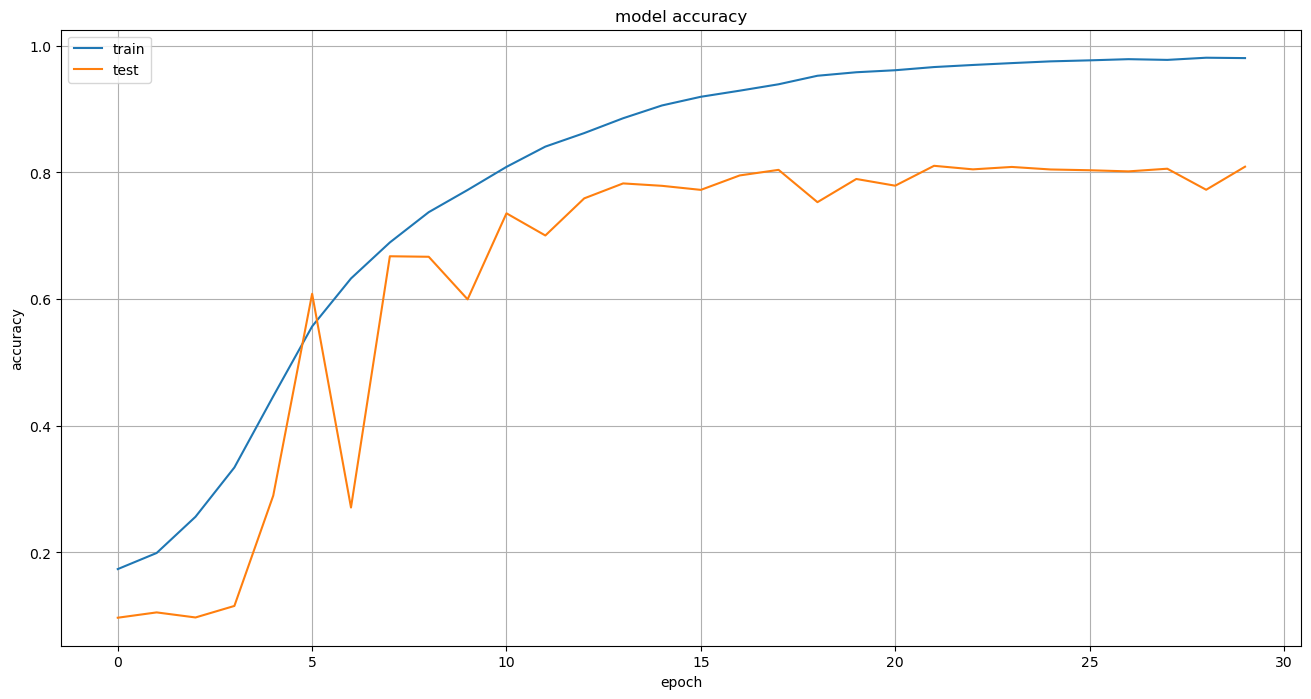

In [16]:
plothist(history)